In [1]:
train = read.csv("train.csv")
train['train_or_test'] = 'train'
test = read.csv("test.csv")
test['train_or_test'] = 'test'

In [2]:
train_target <- train$SaleType
train <- train[names(train) != 'SalePrice']
al <- rbind(train, test)

In [3]:
names(al)

[1] "Id"            "MSSubClass"    "MSZoning"      "LotFrontage"  
 [5] "LotArea"       "Street"        "Alley"         "LotShape"     
 [9] "LandContour"   "Utilities"     "LotConfig"     "LandSlope"    
[13] "Neighborhood"  "Condition1"    "Condition2"    "BldgType"     
[17] "HouseStyle"    "OverallQual"   "OverallCond"   "YearBuilt"    
[21] "YearRemodAdd"  "RoofStyle"     "RoofMatl"      "Exterior1st"  
[25] "Exterior2nd"   "MasVnrType"    "MasVnrArea"    "ExterQual"    
[29] "ExterCond"     "Foundation"    "BsmtQual"      "BsmtCond"     
[33] "BsmtExposure"  "BsmtFinType1"  "BsmtFinSF1"    "BsmtFinType2" 
[37] "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"   "Heating"      
[41] "HeatingQC"     "CentralAir"    "Electrical"    "X1stFlrSF"    
[45] "X2ndFlrSF"     "LowQualFinSF"  "GrLivArea"     "BsmtFullBath" 
[49] "BsmtHalfBath"  "FullBath"      "HalfBath"      "BedroomAbvGr" 
[53] "KitchenAbvGr"  "KitchenQual"   "TotRmsAbvGrd"  "Functional"   
[57] "Fireplaces"    "FireplaceQu"   "GarageType"    "GarageYrBlt"  
[61] "GarageFinish"  "GarageCars"    "GarageArea"    "GarageQual"   
[65] "GarageCond"    "PavedDrive"    "WoodDeckSF"    "OpenPorchSF"  
[69] "EnclosedPorch" "X3SsnPorch"    "ScreenPorch"   "PoolArea"     
[73] "PoolQC"        "Fence"         "MiscFeature"   "MiscVal"      
[77] "MoSold"        "YrSold"        "SaleType"      "SaleCondition"
[81] "train_or_test"

In [4]:
desc <- function (variable){
    na <- sum(is.na(al[variable]))

    if (na > 0){
        print(paste('***********', variable, '***********'))
        print(paste("NA values Qty:    ", na))
        print(paste("NA Ratio:    ", round(na/nrow(al), 3)))
}
    else{
        print("Na values Qty: 0")
    }
    if (is.numeric(al[[variable]])){
            hist(al[[variable]], xlab = "", main = paste("Histogram of ", toupper(variable)))}
    
    else if (is.character(al[[variable]]) | is.factor(al[[variable]])){
            barplot(prop.table(table(al[[variable]])), main = paste("Barplot of ", toupper(variable)))
}
    
}

[1] "Na values Qty: 0"


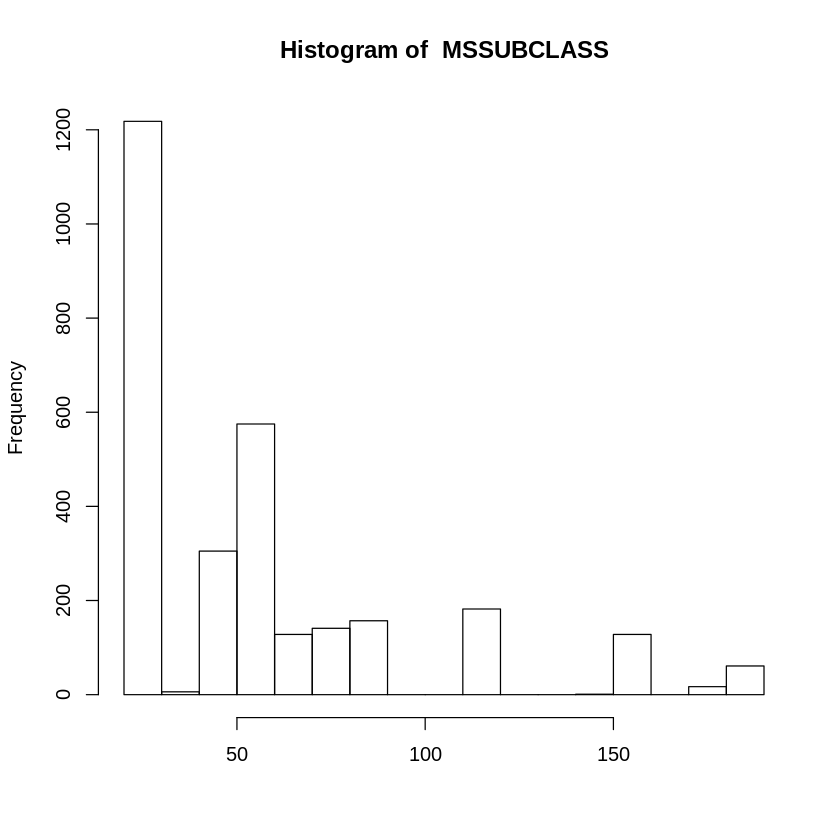

In [5]:
desc('MSSubClass')

[1] "*********** MSZoning ***********"
[1] "NA values Qty:     4"
[1] "NA Ratio:     0.001"


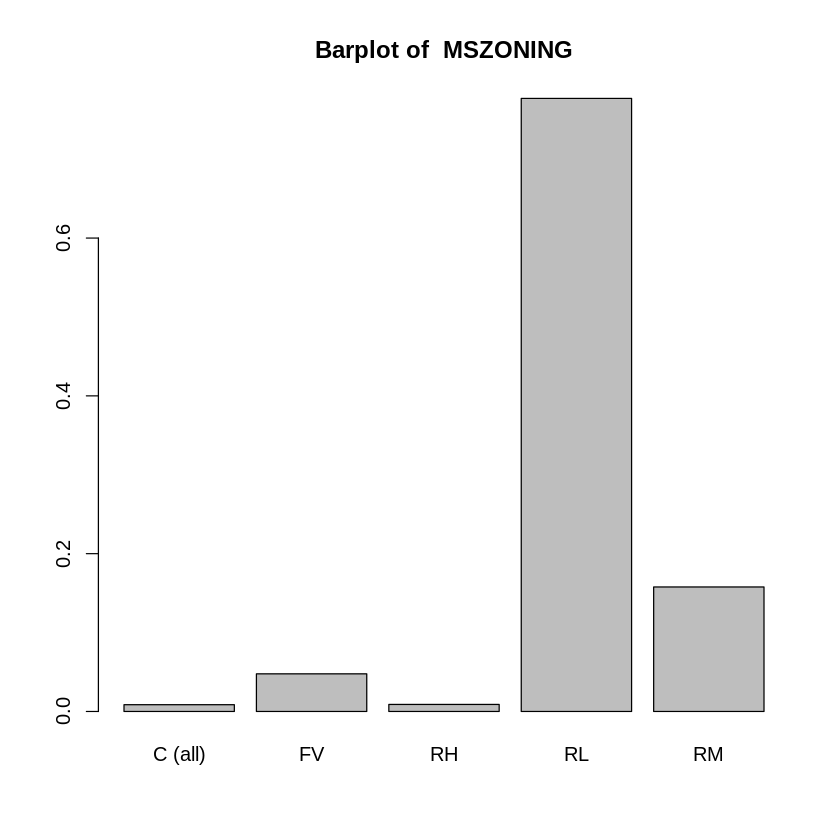

In [6]:
desc("MSZoning")

In [7]:
al[is.na(al['MSZoning']),]$MSZoning <- names(which.max(table(al['MSZoning'])))

[1] "*********** LotFrontage ***********"
[1] "NA values Qty:     486"
[1] "NA Ratio:     0.166"


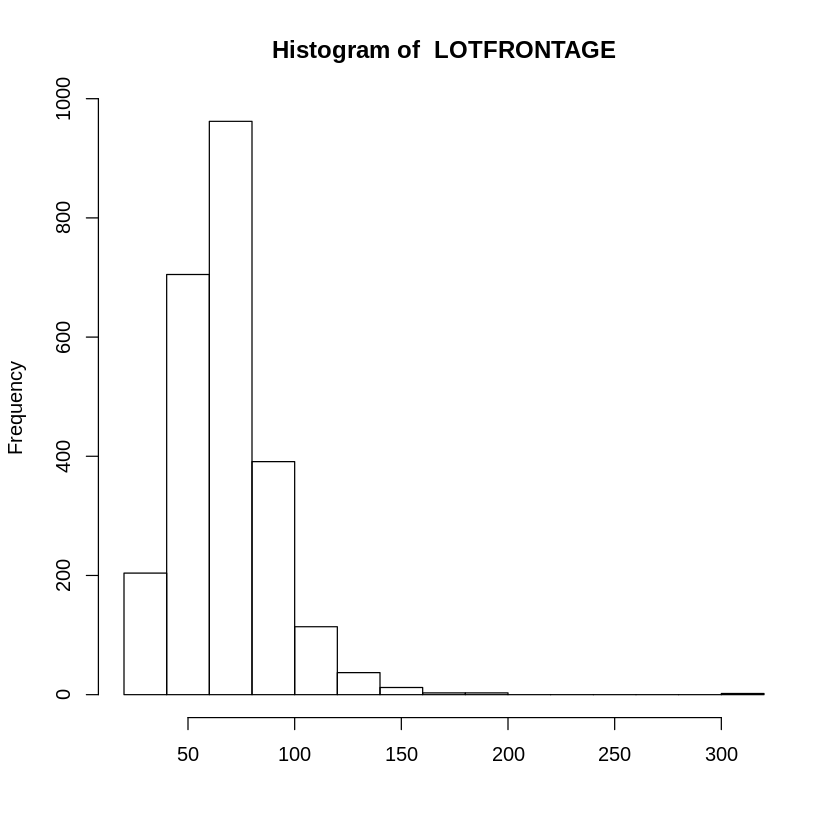

In [8]:
desc('LotFrontage')

In [9]:
al$LotFrontage[is.na(al$LotFrontage)] <- mean(al$LotFrontage, na.rm = TRUE)

[1] "Na values Qty: 0"


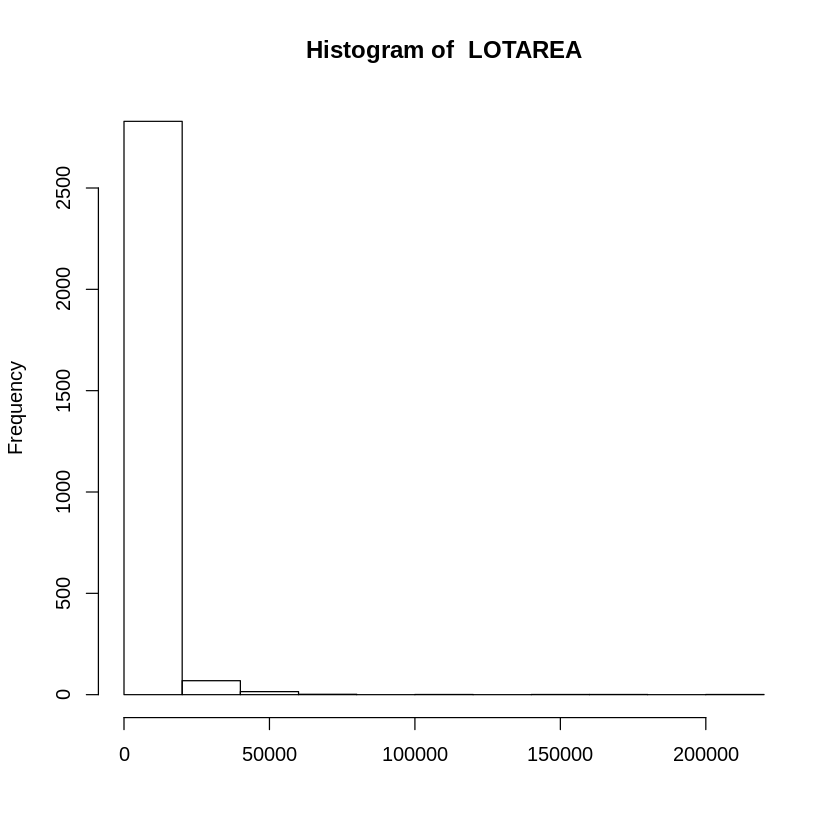

In [10]:
desc("LotArea")

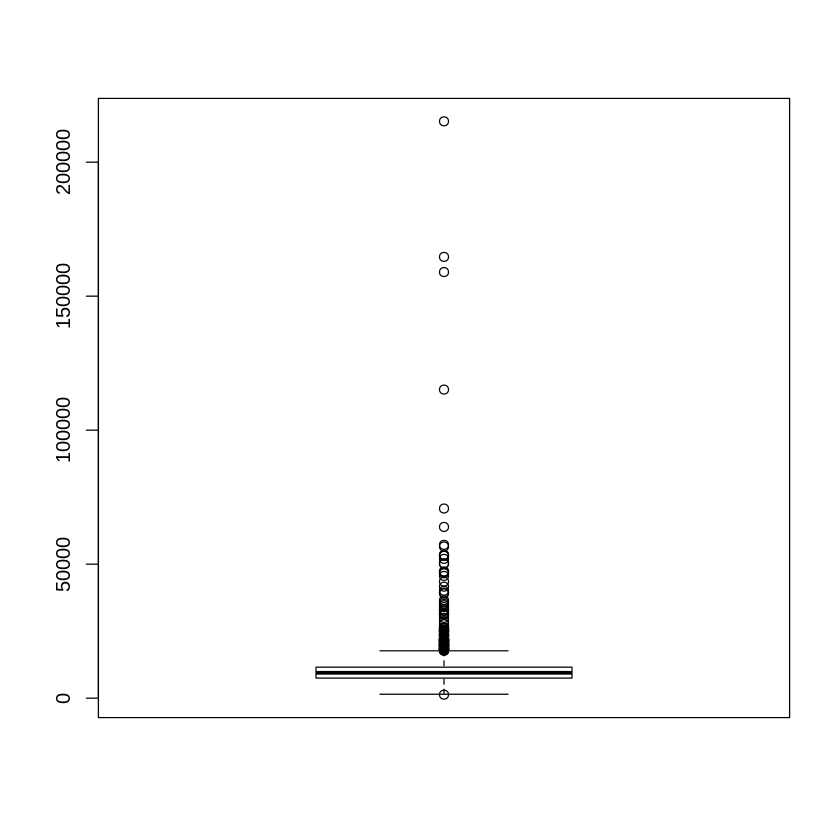

In [11]:
boxplot(al$LotArea)

In [12]:
al <- al[al$LotArea < 30000, ]

[1] "Na values Qty: 0"


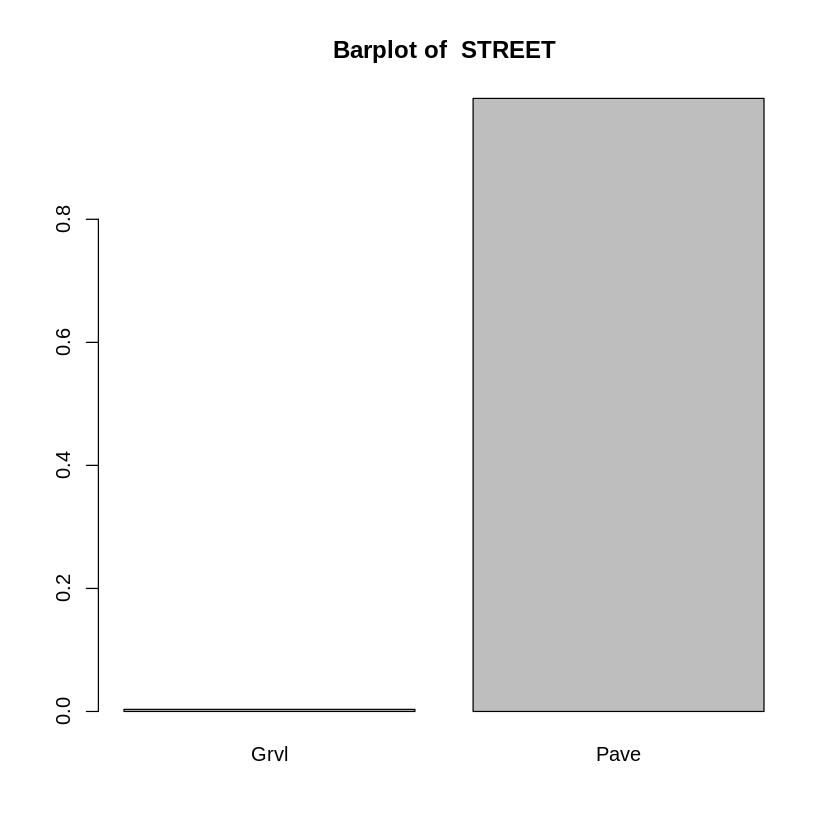

In [13]:
desc("Street")

In [14]:
prop.table(table(al$Street))


       Grvl        Pave 
0.003467406 0.996532594 

In [15]:
# Here 99.65% ot the data is identical, so we drop this variable
al <- al[!names(al) == 'Street']

[1] "*********** Alley ***********"
[1] "NA values Qty:     2686"
[1] "NA Ratio:     0.931"


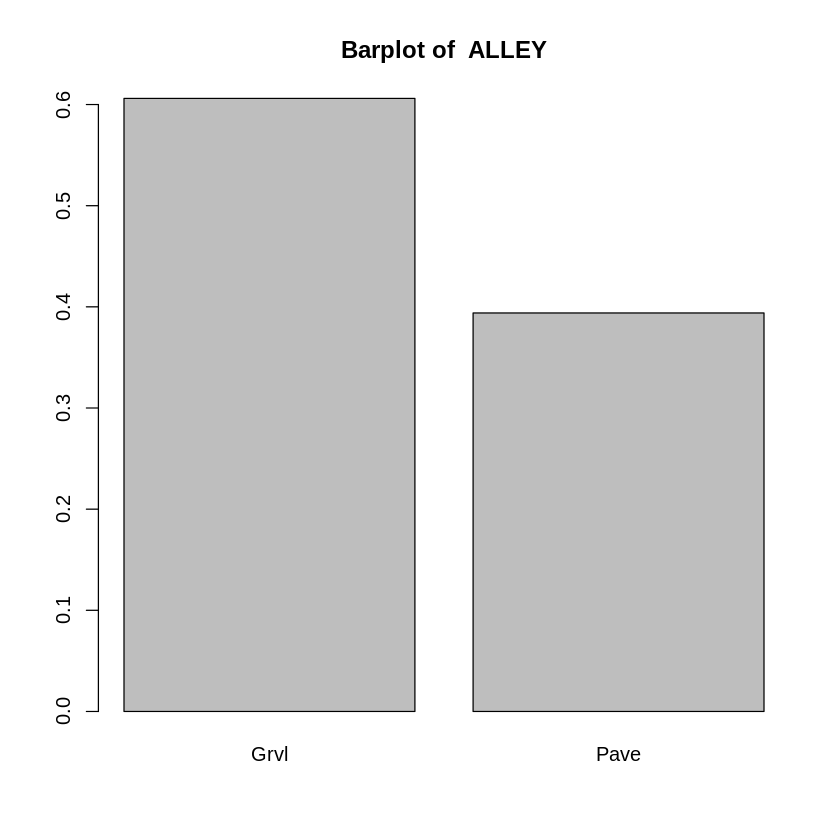

In [16]:
desc("Alley")

In [17]:
# In variables_discription file(for Alley variable): NA = "No alley access"
b = as.character(al$Alley)
b[is.na(b)] <- 'No alley access'
al$Alley <- as.factor(b)

[1] "Na values Qty: 0"


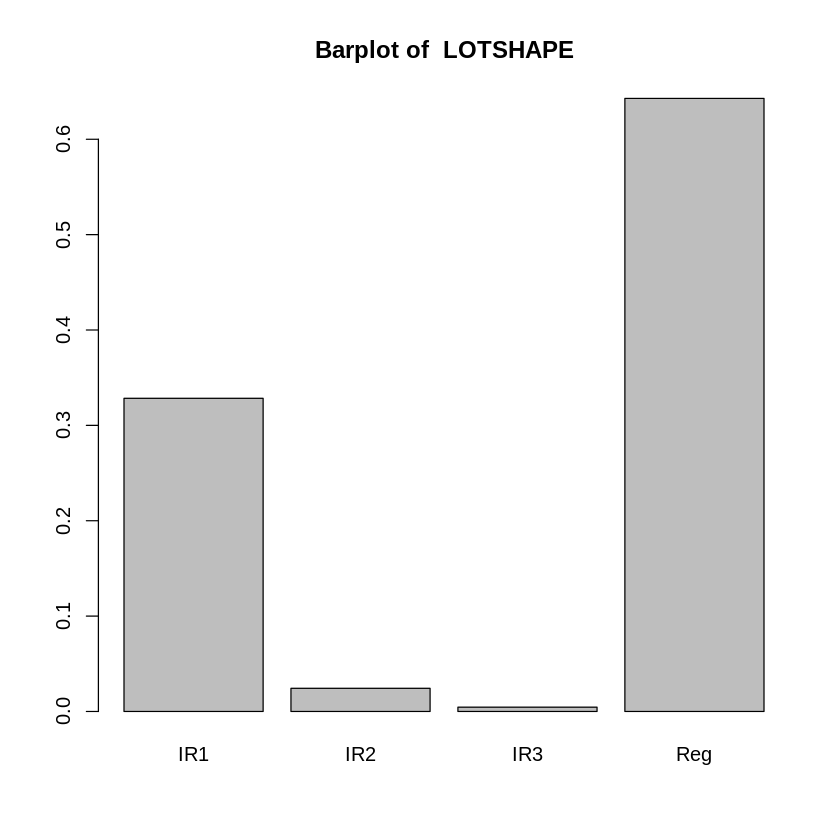

In [18]:
desc('LotShape')

[1] "Na values Qty: 0"


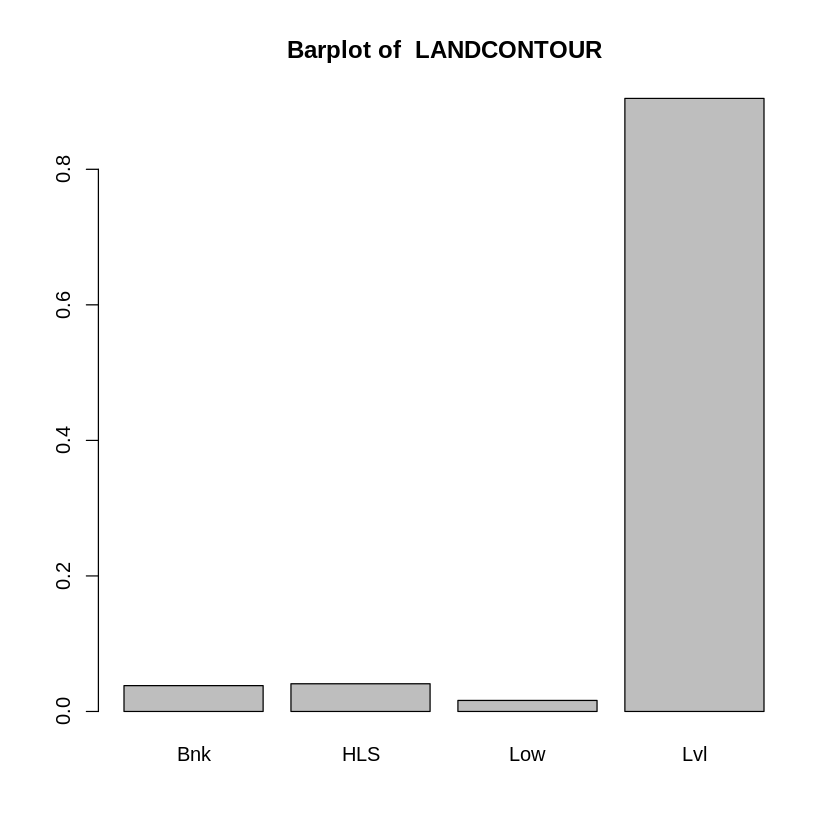

In [19]:
desc('LandContour')

[1] "*********** Utilities ***********"
[1] "NA values Qty:     1"
[1] "NA Ratio:     0"


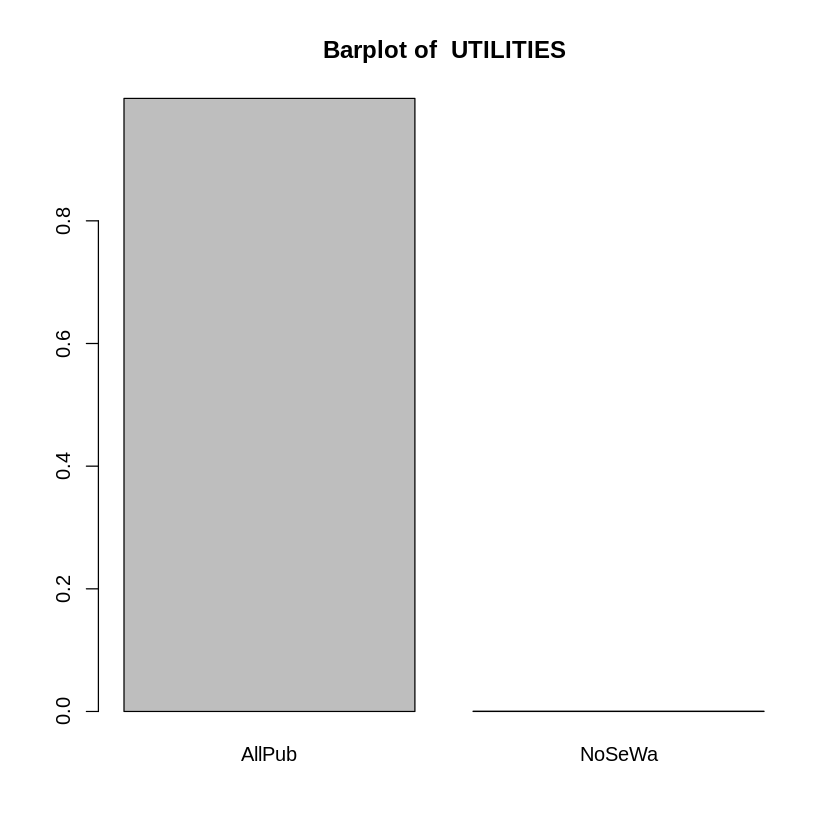

In [20]:
desc('Utilities')

In [21]:
prop.table(table(al$Utilities))


      AllPub       NoSeWa 
0.9996531391 0.0003468609 

In [22]:
# Here about 99.9 % of data is identical, so we drop this variable
al <- al[!names(al) == "Utilities"]

[1] "Na values Qty: 0"


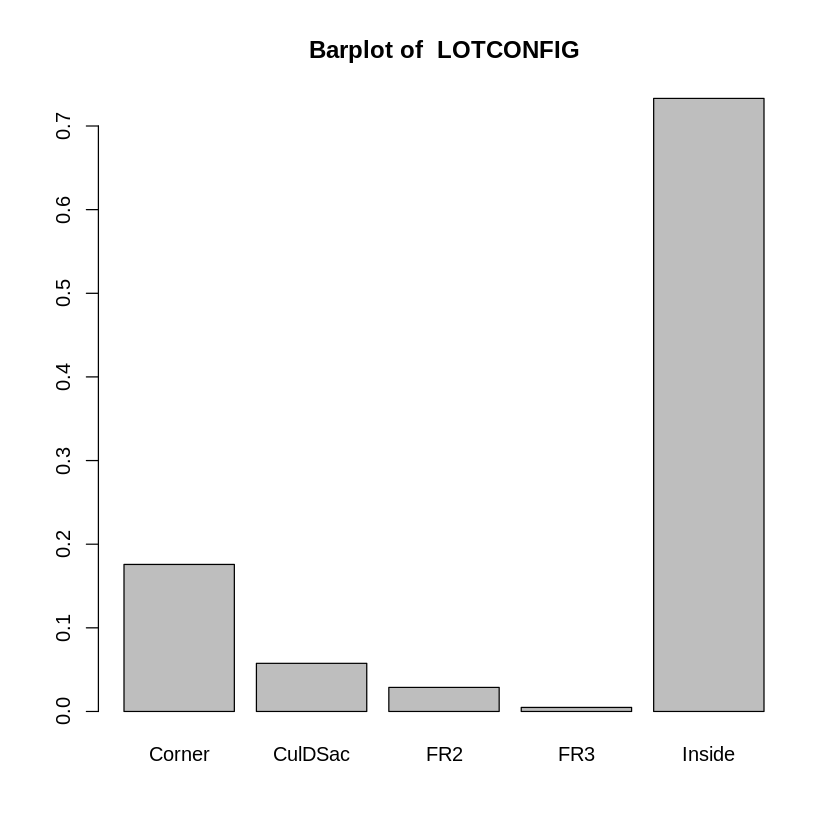

In [23]:
desc('LotConfig')

[1] "Na values Qty: 0"


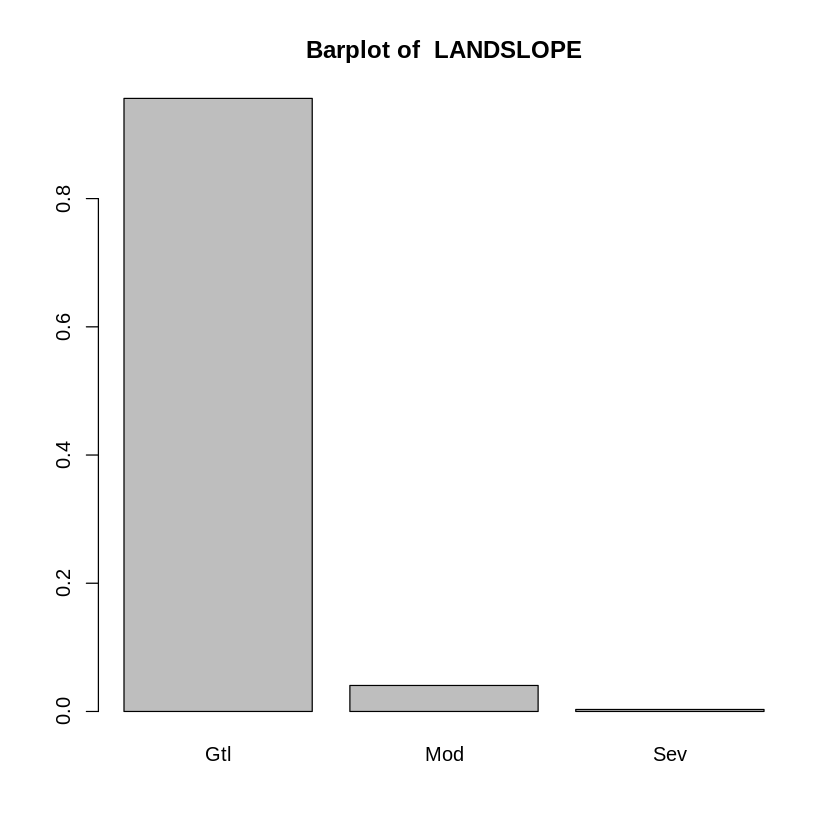

In [24]:
desc('LandSlope')

[1] "Na values Qty: 0"


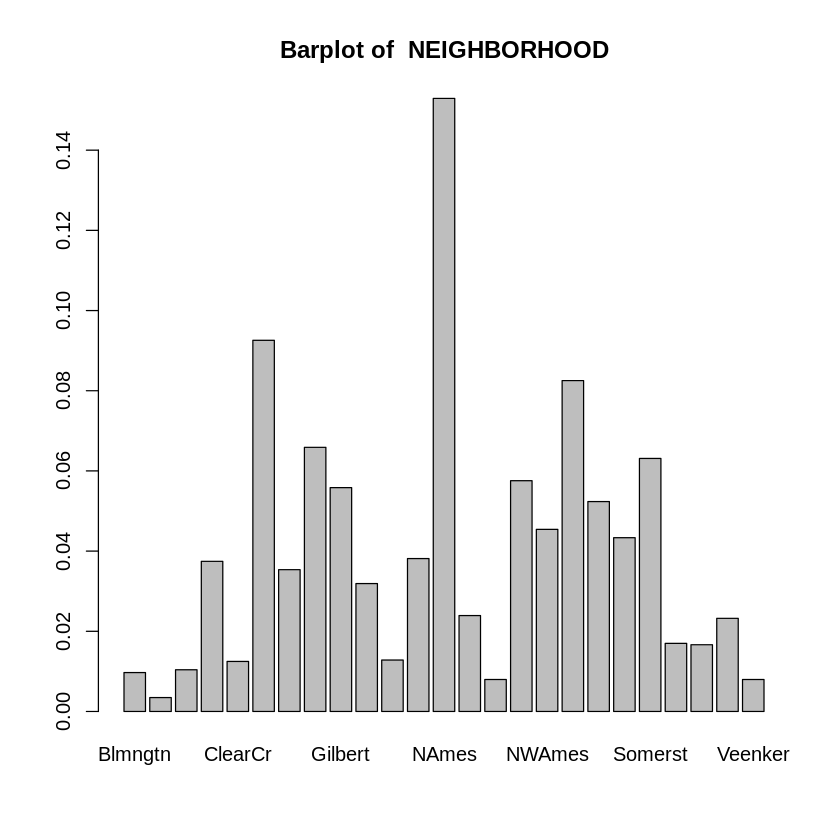

In [25]:
desc('Neighborhood')

[1] "Na values Qty: 0"


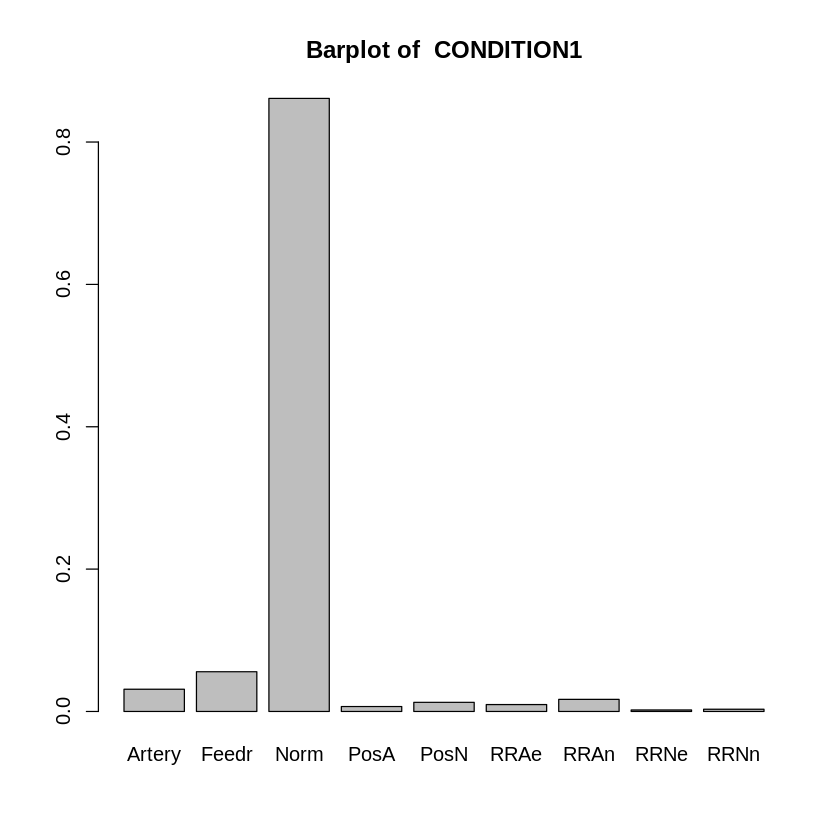

In [26]:
desc('Condition1')

[1] "Na values Qty: 0"


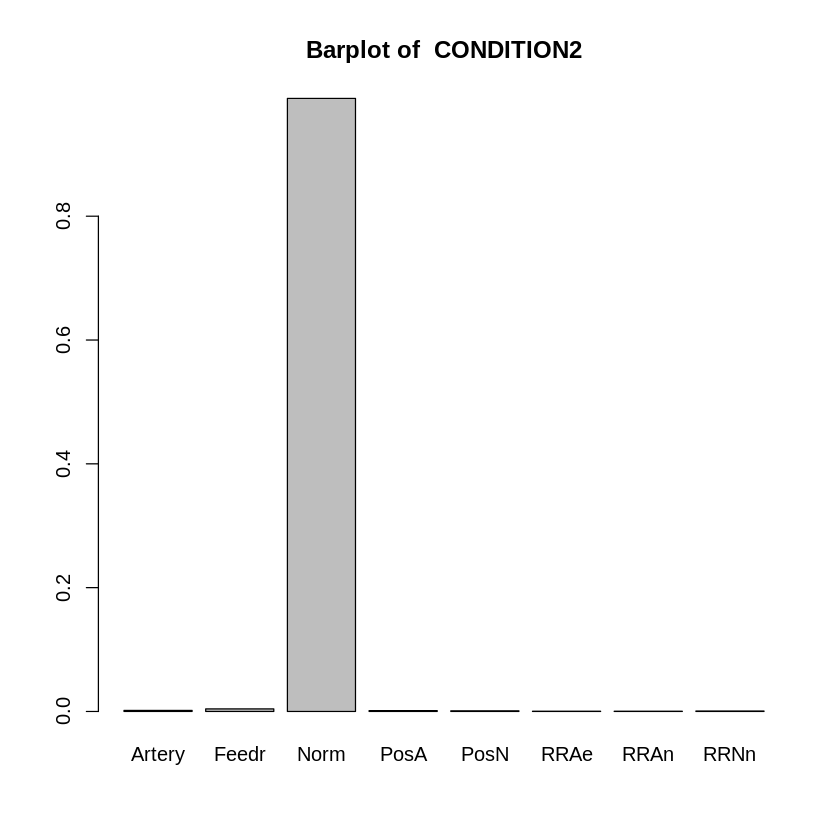

In [27]:
desc("Condition2")

In [28]:
prop.table(table(al$Condition2))


      Artery        Feedr         Norm         PosA         PosN         RRAe 
0.0017337032 0.0041608877 0.9902912621 0.0013869626 0.0010402219 0.0003467406 
        RRAn         RRNn 
0.0003467406 0.0006934813 

In [29]:
# Here 99% of the data is identical, so we drop it
al <- al[!names(al) == 'Condition2']

[1] "Na values Qty: 0"


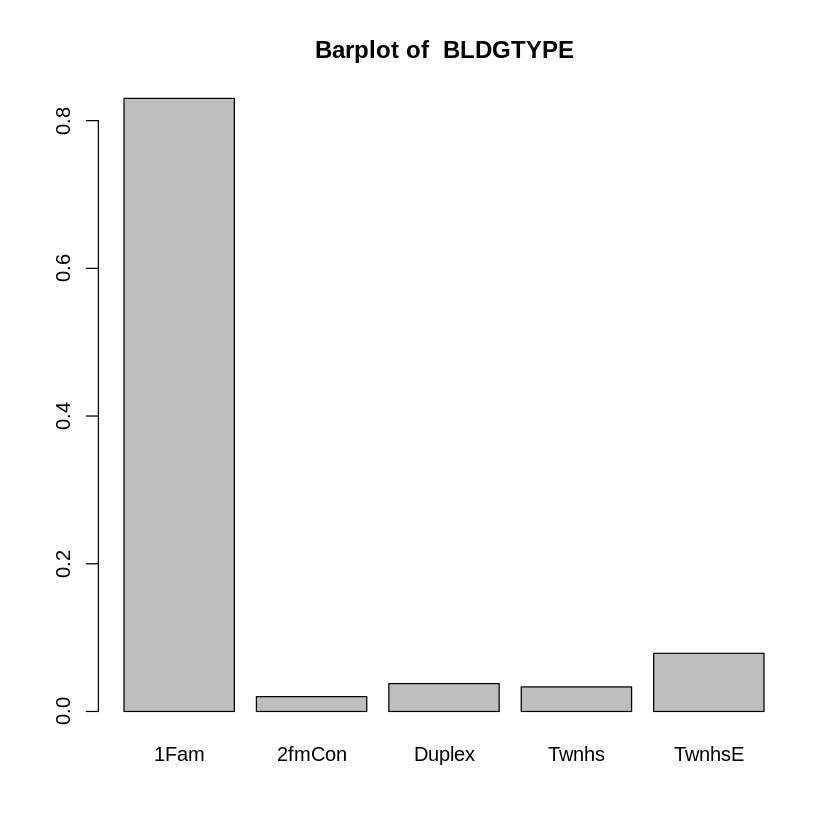

In [30]:
desc("BldgType")

[1] "Na values Qty: 0"


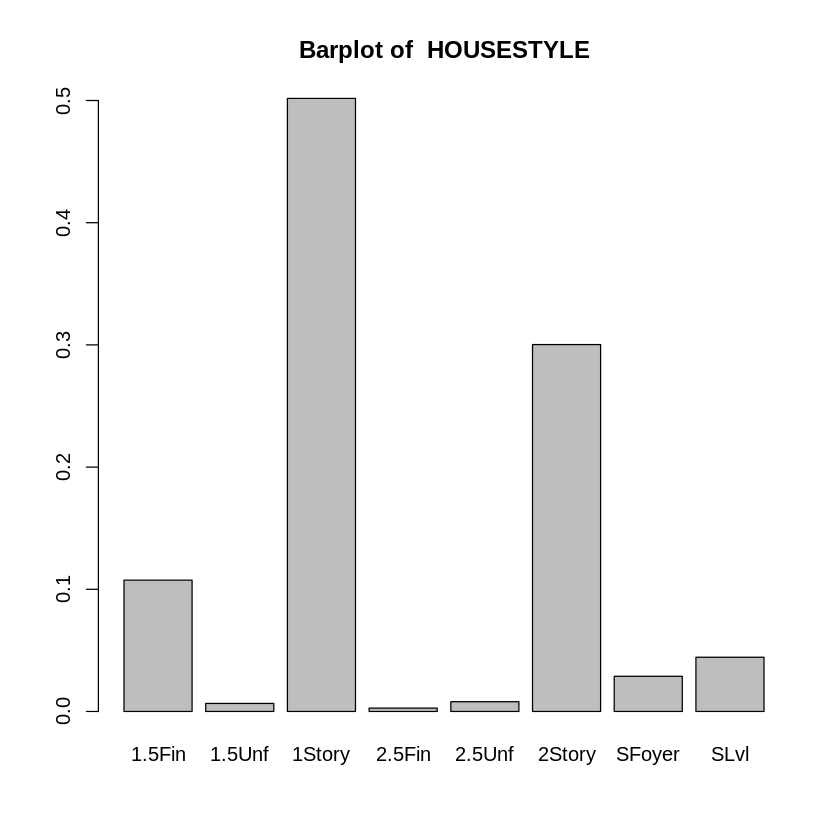

In [31]:
desc("HouseStyle")

[1] "Na values Qty: 0"


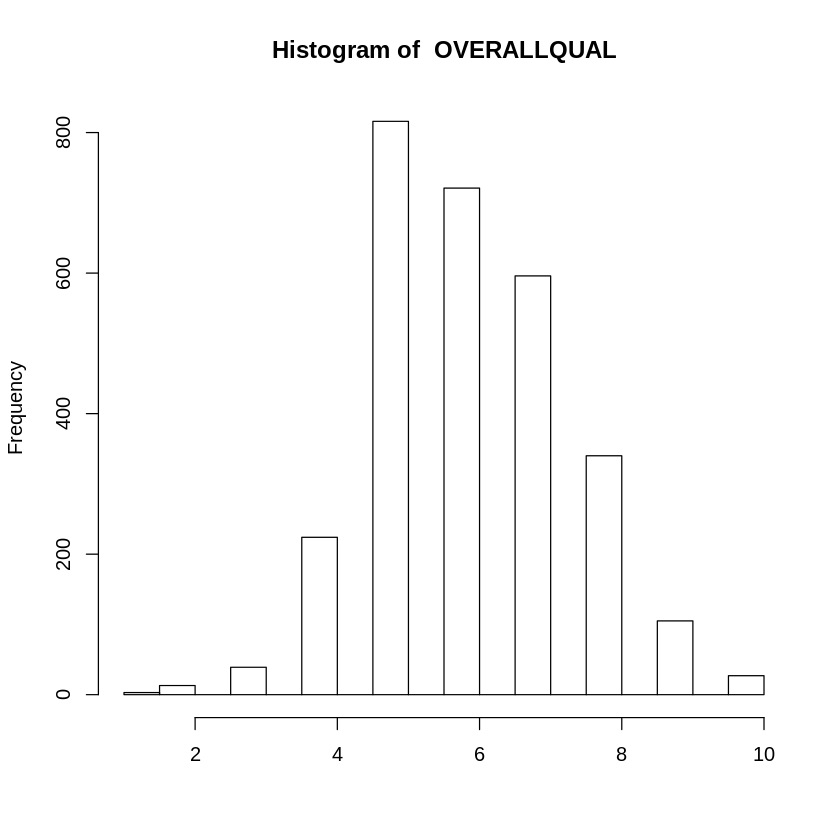

In [32]:
desc("OverallQual")

[1] "Na values Qty: 0"


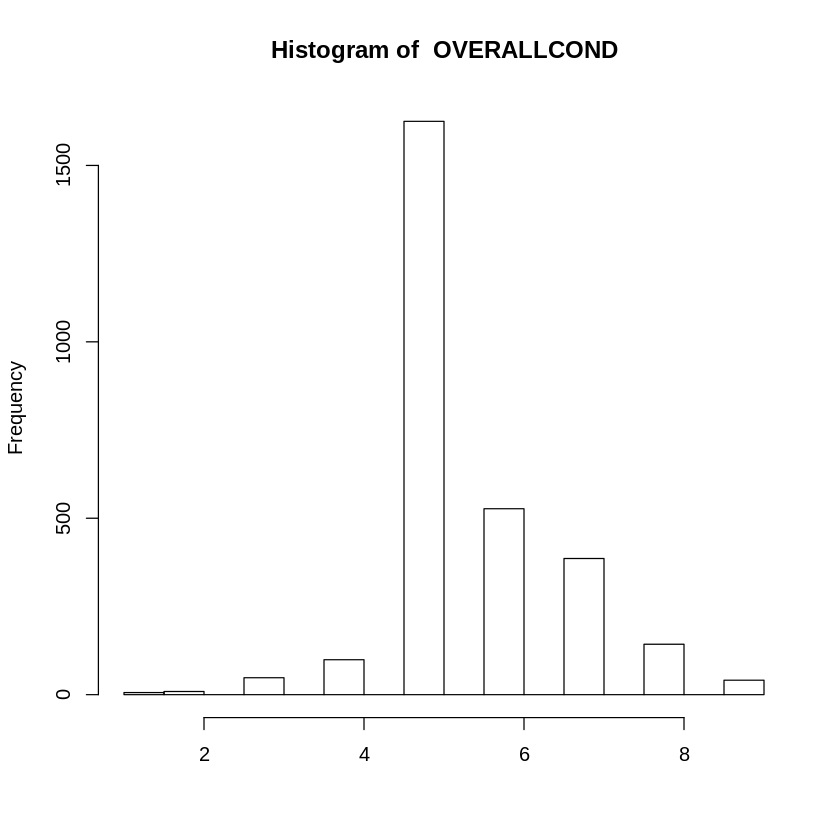

In [33]:
desc("OverallCond")

[1] "Na values Qty: 0"


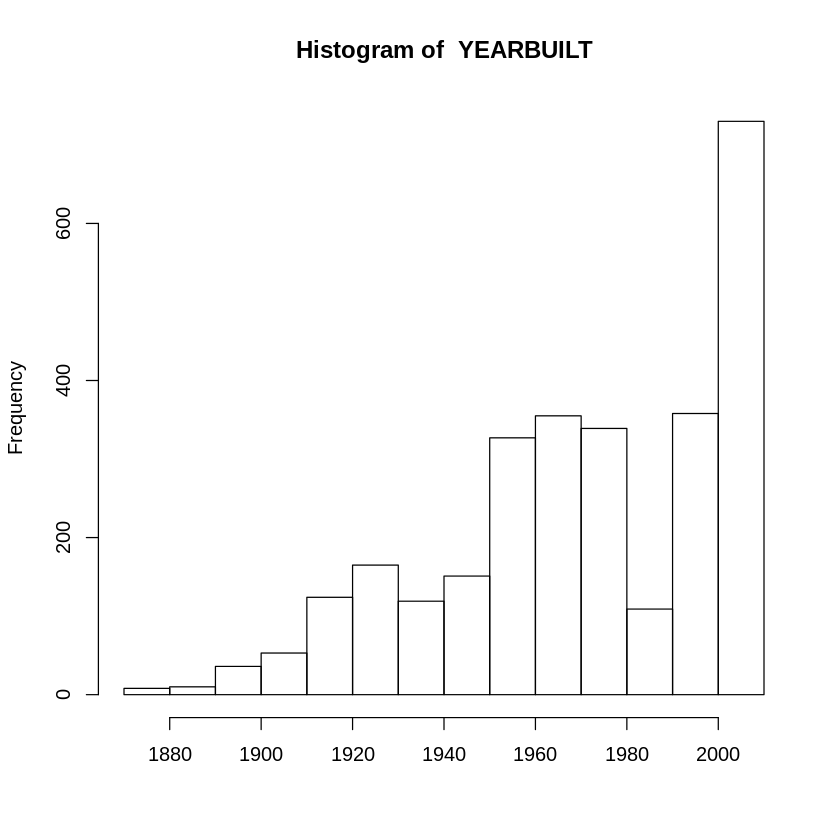

In [34]:
desc("YearBuilt")

[1] "Na values Qty: 0"


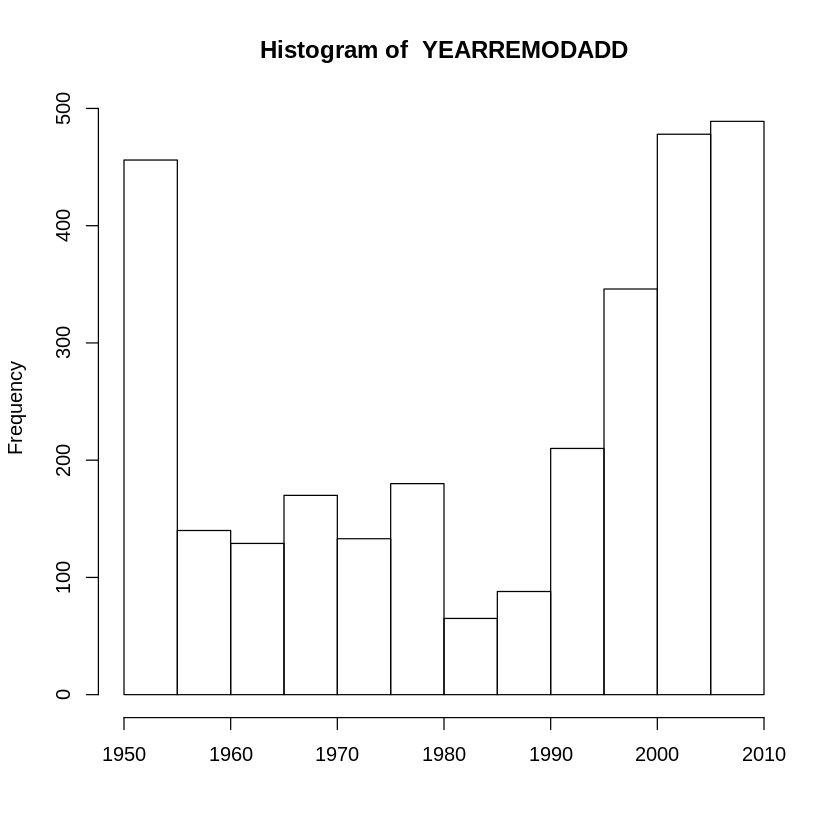

In [35]:
desc("YearRemodAdd")

[1] "Na values Qty: 0"


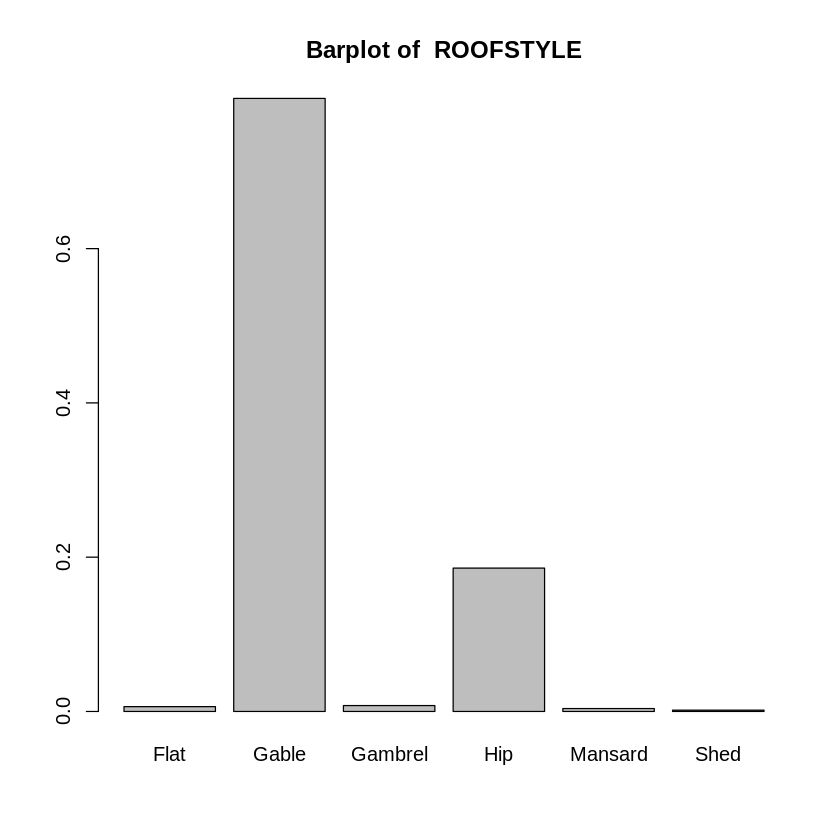

In [36]:
desc("RoofStyle")

[1] "Na values Qty: 0"


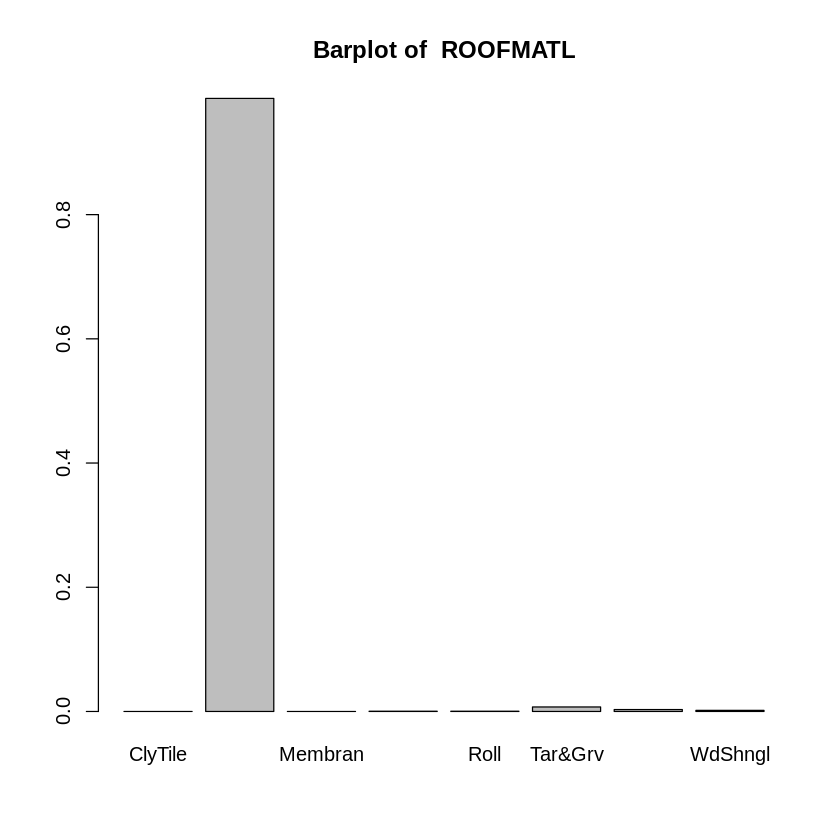

In [37]:
desc("RoofMatl")

In [38]:
prop.table(table(al$RoofMatl))


     ClyTile      CompShg      Membran        Metal         Roll      Tar&Grv 
0.0000000000 0.9871705964 0.0000000000 0.0003467406 0.0003467406 0.0072815534 
     WdShake      WdShngl 
0.0031206657 0.0017337032 

In [39]:
# Here 98.7% of the data is identica, so we drop this variable
al <- al[!names(al) == "RoofMatl"]

[1] "*********** Exterior1st ***********"
[1] "NA values Qty:     1"
[1] "NA Ratio:     0"


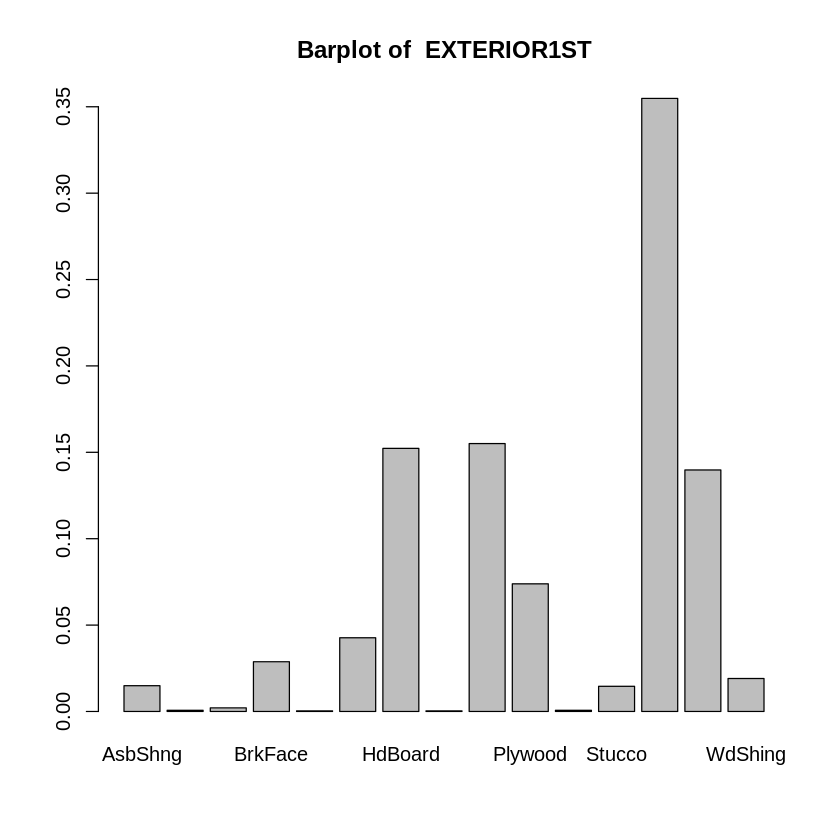

In [40]:
desc("Exterior1st")

In [41]:
al[is.na(al['Exterior1st']),]$Exterior1st <- names(which.max(table(al['Exterior1st'])))

[1] "*********** Exterior2nd ***********"
[1] "NA values Qty:     1"
[1] "NA Ratio:     0"


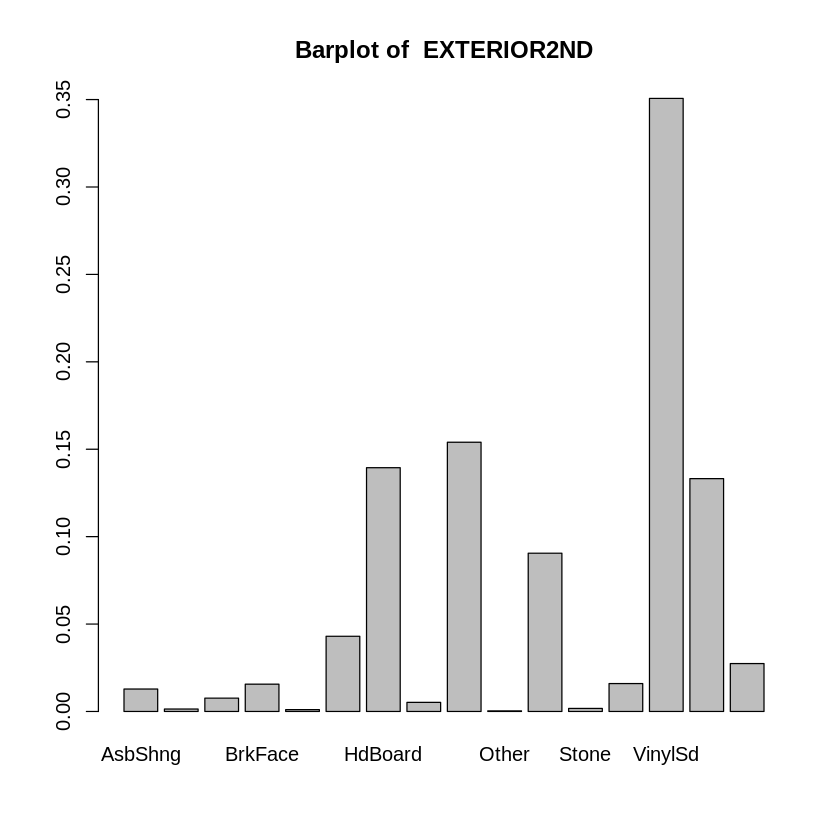

In [42]:
desc("Exterior2nd")

In [43]:
al[is.na(al['Exterior2nd']),]$Exterior2nd <- names(which.max(table(al['Exterior2nd'])))

[1] "*********** MasVnrType ***********"
[1] "NA values Qty:     23"
[1] "NA Ratio:     0.008"


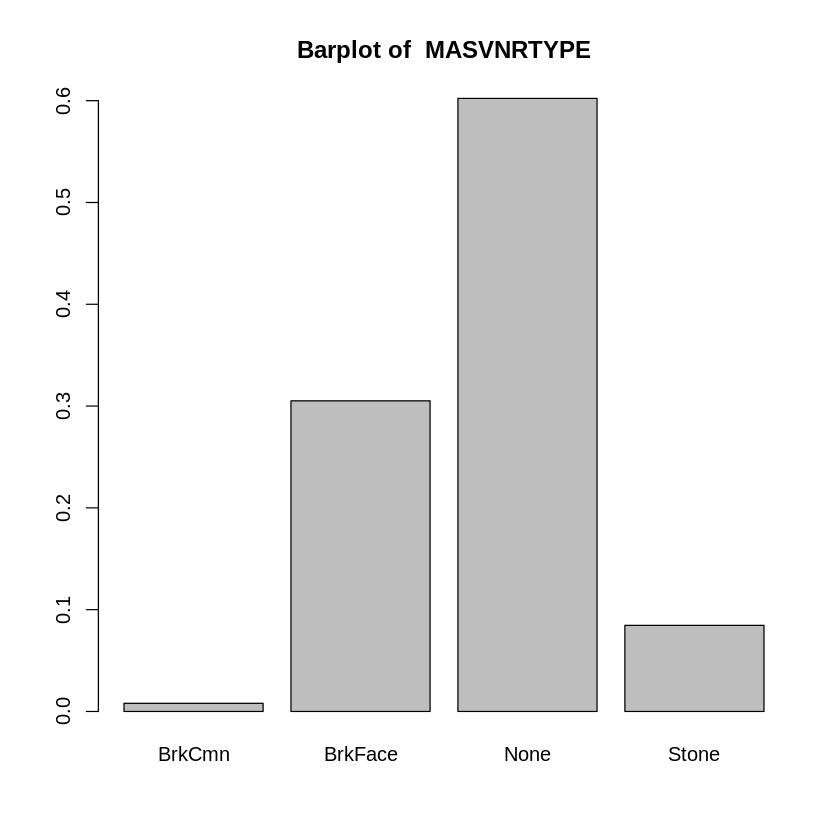

In [44]:
desc("MasVnrType")

[1] "*********** MasVnrArea ***********"
[1] "NA values Qty:     22"
[1] "NA Ratio:     0.008"


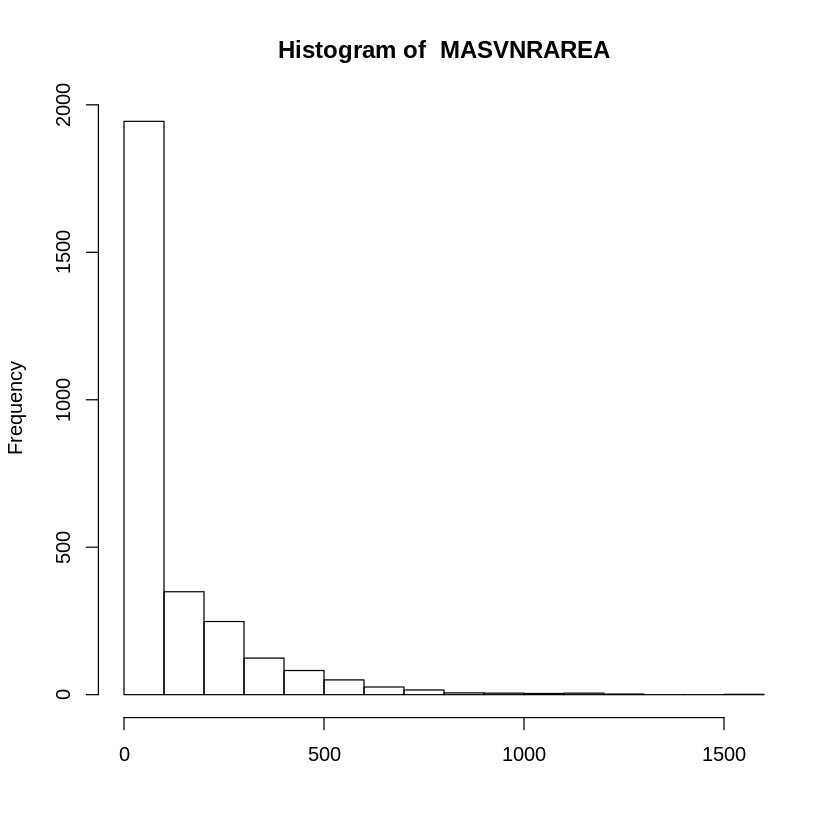

In [46]:
desc("MasVnrArea")

In [47]:
al$MasVnrArea[is.na(al$MasVnrArea)] <- mean(al$MasVnrArea, na.rm = TRUE)

[1] "Na values Qty: 0"


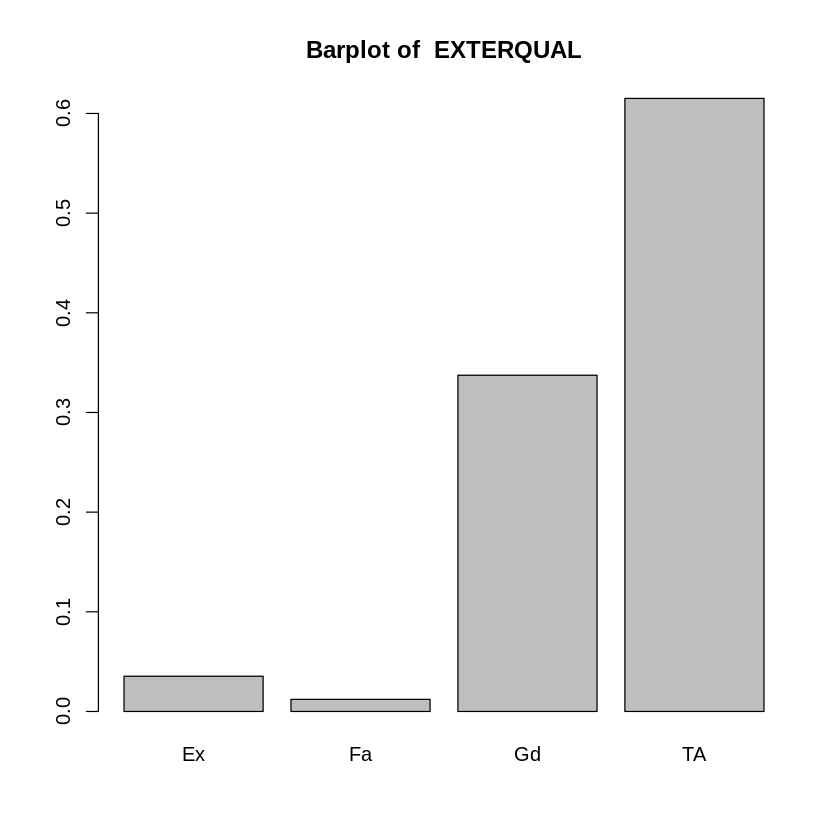

In [48]:
desc("ExterQual")

[1] "Na values Qty: 0"


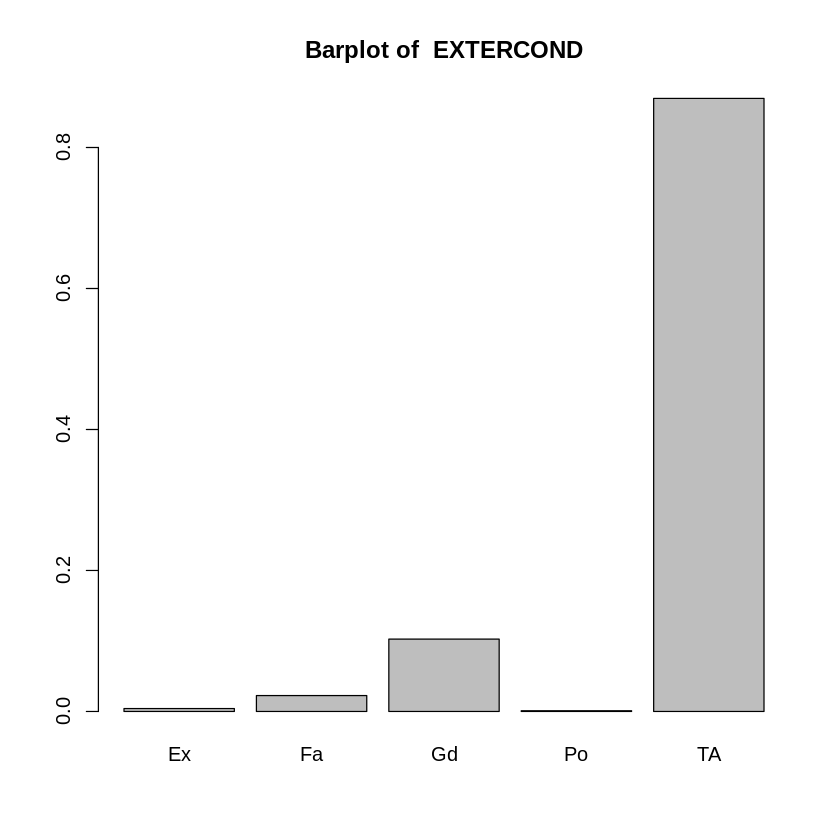

In [49]:
desc("ExterCond")

[1] "Na values Qty: 0"


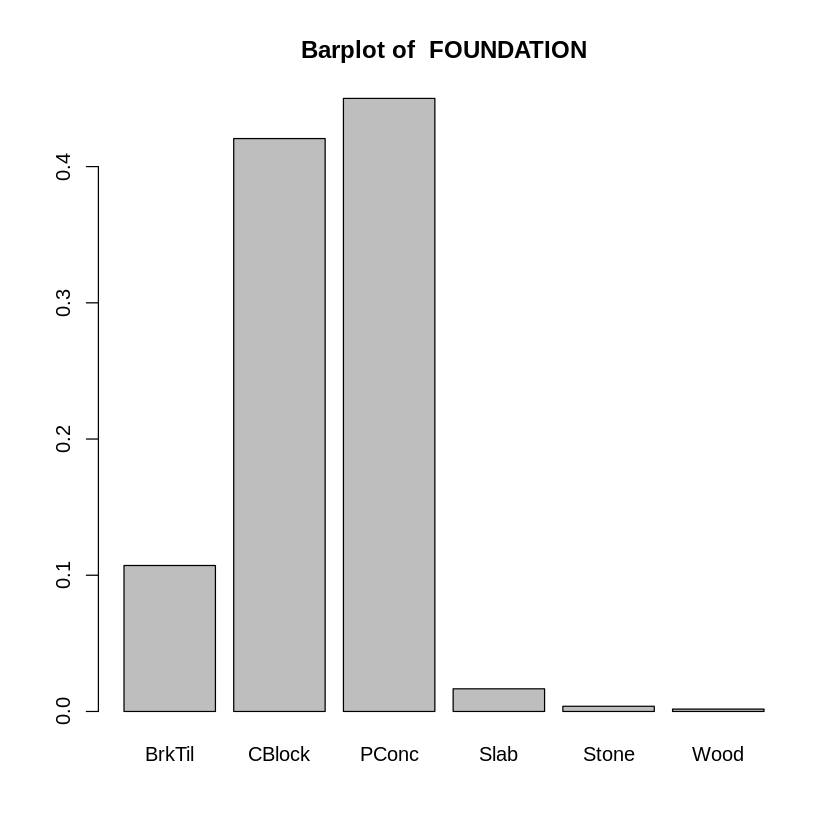

In [50]:
desc("Foundation")

[1] "*********** BsmtQual ***********"
[1] "NA values Qty:     78"
[1] "NA Ratio:     0.027"


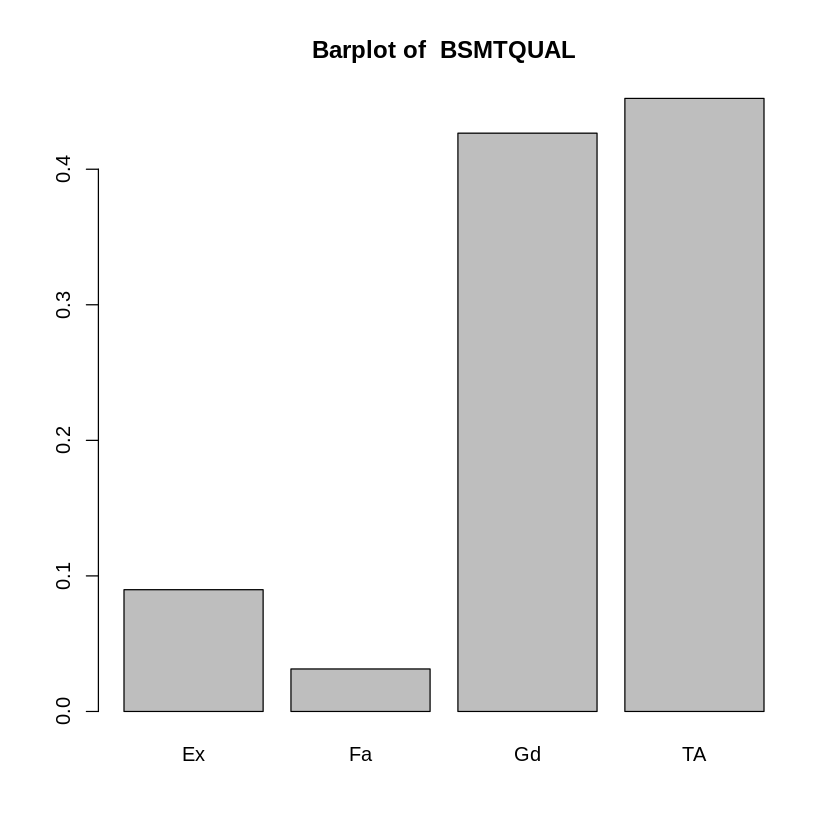

In [51]:
desc("BsmtQual")

In [26]:
library(purrr)
library(dplyr)
library(corrplot)
library(hablar)
library(corrplot)
library(RColorBrewer)
library(MASS)
library(stats)

In [2]:
df <- read.csv("cleaned_data.csv")
df <- df %>% convert(int(GarageYrBlt))
df$GarageYrBlt[is.na(df$GarageYrBlt)] = 0

Warning message in as_reliable_int(GarageYrBlt):
“NAs introduced by coercion”

In [3]:
a <- data.frame(sapply(df, class))
names(a) <- c("class")
a

,class
X1stFlrSF,integer
X2ndFlrSF,integer
Alley,factor
BedroomAbvGr,integer
BldgType,factor
BsmtCond,factor
BsmtExposure,factor
BsmtFinSF1,numeric
BsmtFinSF2,numeric
BsmtFinType1,factor


In [4]:
a %>%
    group_by(class) %>% 
    tally()

class,n
factor,38
integer,23
numeric,12


In [47]:
train <- df[df$train_or_test == 'train',]
train <- train[ , -which(names(train) == 'train_or_test')]

test <- df[df$train_or_test == 'test',]
test <- test[ , -which(names(test) == 'train_or_test')]

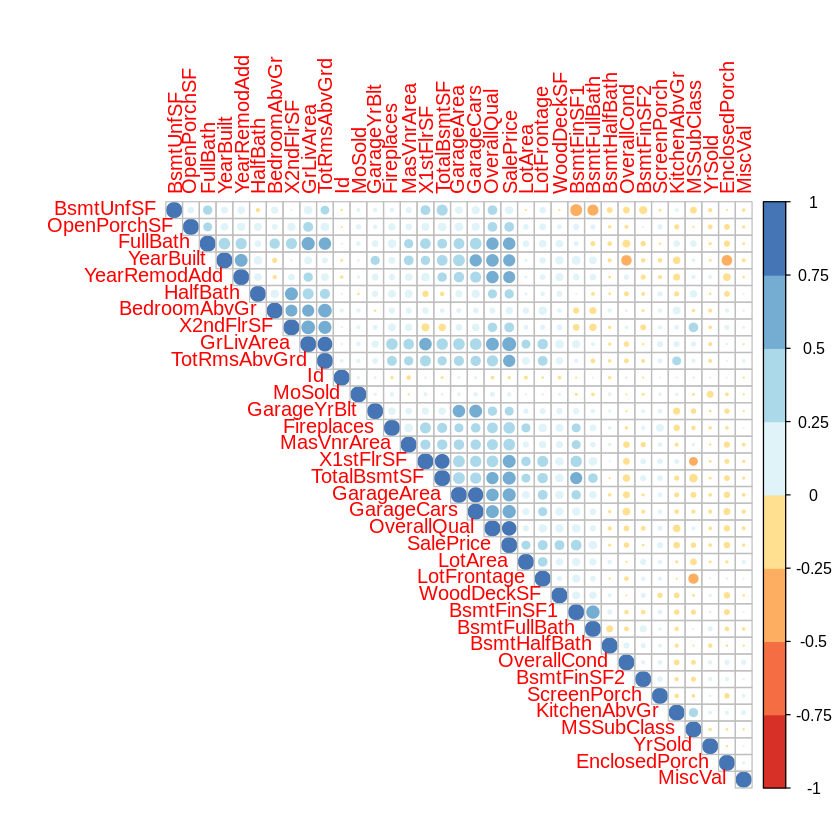

In [9]:
corrplot(cor(train %>% keep(is.numeric)), type="upper", order="hclust",
         col=brewer.pal(n=8, name="RdYlBu"))

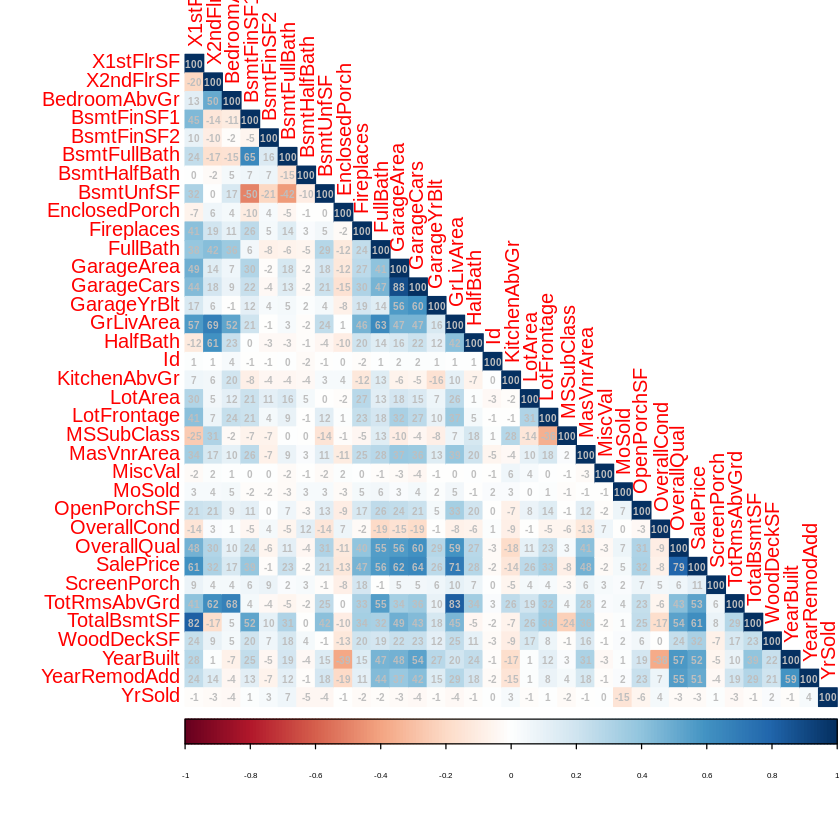

In [10]:
cex.before <- par("cex")
par(cex = 0.5)
corrplot(cor(train %>% keep(is.numeric)), insig = "blank", method = "color",
    addCoef.col="grey", type='lower',
    tl.cex = 1/par("cex"), addCoefasPercent = TRUE)
par(cex = cex.before)

In [11]:
# check if case to lower reduce number of unique values
for (i in names(train %>% keep(is.factor))){
    a = table(train[[i]])
    b = table(tolower(train[[i]]))
    if (!all(a==b)){
        print(i)
    }
    
}

In [12]:
lm1 <- lm(SalePrice ~ ., data=train)

In [14]:
names(which.min(summary(lm1)$coefficients[,4]))

[1] "OverallQual"

In [16]:
a = data.frame(summary(lm1)$coefficients)
a[order(a$Pr...t..),]

,Estimate,Std..Error,t.value,Pr...t..
OverallQual,7.699926e+03,1.205975e+03,6.384814,2.424994e-10
BsmtQualGd,-2.527810e+04,4.017539e+03,-6.291937,4.346979e-10
KitchenQualGd,-2.555261e+04,4.193988e+03,-6.092677,1.481817e-09
KitchenQualTA,-2.513492e+04,4.718060e+03,-5.327384,1.183462e-07
NeighborhoodStoneBr,5.098325e+04,9.977923e+03,5.109605,3.738073e-07
GarageCars,1.346132e+04,2.678225e+03,5.026209,5.740972e-07
LotArea,5.978521e-01,1.235432e-01,4.839214,1.468357e-06
GarageQualFa,-1.603765e+05,3.353469e+04,-4.782406,1.940877e-06
NeighborhoodNoRidge,4.770194e+04,1.010855e+04,4.718971,2.641149e-06
BsmtQualTA,-2.335829e+04,4.982119e+03,-4.688425,3.059516e-06


In [21]:
# Automated variable selection
fit <- lm(formula = SalePrice ~ ., data = train) 
automate_variable_selection <- stepAIC(fit, direction="both")

Start:  AIC=30048.03
SalePrice ~ X1stFlrSF + X2ndFlrSF + Alley + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtFinType1 + 
    BsmtFinType2 + BsmtFullBath + BsmtHalfBath + BsmtQual + BsmtUnfSF + 
    CentralAir + Condition1 + Electrical + EnclosedPorch + ExterCond + 
    ExterQual + Exterior1st + Exterior2nd + Fence + FireplaceQu + 
    Fireplaces + Foundation + FullBath + Functional + GarageArea + 
    GarageCars + GarageCond + GarageFinish + GarageQual + GarageType + 
    GarageYrBlt + GrLivArea + HalfBath + HeatingQC + HouseStyle + 
    Id + KitchenAbvGr + KitchenQual + LandContour + LandSlope + 
    LotArea + LotConfig + LotFrontage + LotShape + MSSubClass + 
    MSZoning + MasVnrArea + MasVnrType + MiscFeature + MiscVal + 
    MoSold + Neighborhood + OpenPorchSF + OverallCond + OverallQual + 
    PavedDrive + RoofStyle + SaleCondition + SaleType + ScreenPorch + 
    TotRmsAbvGrd + TotalBsmtSF + WoodDeckSF + YearBuilt + YearRemodAdd + 
    Y


Step:  AIC=30029.68
SalePrice ~ X1stFlrSF + X2ndFlrSF + Alley + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtFinType1 + 
    BsmtFullBath + BsmtHalfBath + BsmtQual + BsmtUnfSF + CentralAir + 
    Condition1 + Electrical + EnclosedPorch + ExterCond + ExterQual + 
    Exterior1st + Fence + FireplaceQu + Fireplaces + Foundation + 
    FullBath + Functional + GarageArea + GarageCars + GarageCond + 
    GarageFinish + GarageQual + GarageType + GarageYrBlt + GrLivArea + 
    HalfBath + HeatingQC + HouseStyle + Id + KitchenAbvGr + KitchenQual + 
    LandContour + LandSlope + LotArea + LotConfig + LotFrontage + 
    LotShape + MSSubClass + MSZoning + MasVnrArea + MasVnrType + 
    MiscFeature + MiscVal + MoSold + Neighborhood + OpenPorchSF + 
    OverallCond + OverallQual + PavedDrive + RoofStyle + SaleCondition + 
    SaleType + ScreenPorch + TotRmsAbvGrd + WoodDeckSF + YearBuilt + 
    YearRemodAdd + YrSold

                Df  Sum of Sq        RSS 


Step:  AIC=30017.32
SalePrice ~ X1stFlrSF + X2ndFlrSF + Alley + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtFinType1 + 
    BsmtFullBath + BsmtHalfBath + BsmtQual + BsmtUnfSF + CentralAir + 
    Condition1 + EnclosedPorch + ExterCond + ExterQual + Exterior1st + 
    Fence + Fireplaces + Foundation + FullBath + Functional + 
    GarageArea + GarageCars + GarageCond + GarageFinish + GarageQual + 
    GarageType + GarageYrBlt + GrLivArea + HalfBath + HeatingQC + 
    HouseStyle + Id + KitchenAbvGr + KitchenQual + LandContour + 
    LandSlope + LotArea + LotConfig + LotFrontage + LotShape + 
    MSSubClass + MSZoning + MasVnrArea + MasVnrType + MiscFeature + 
    MiscVal + MoSold + Neighborhood + OpenPorchSF + OverallCond + 
    OverallQual + PavedDrive + RoofStyle + SaleCondition + SaleType + 
    ScreenPorch + TotRmsAbvGrd + WoodDeckSF + YearBuilt + YearRemodAdd + 
    YrSold

                Df  Sum of Sq        RSS   AIC
- ExterCond      4 1.


Step:  AIC=30006.45
SalePrice ~ X1stFlrSF + X2ndFlrSF + Alley + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtFinType1 + 
    BsmtFullBath + BsmtHalfBath + BsmtQual + BsmtUnfSF + CentralAir + 
    Condition1 + EnclosedPorch + ExterQual + Exterior1st + Fence + 
    Fireplaces + Foundation + FullBath + Functional + GarageArea + 
    GarageCars + GarageCond + GarageFinish + GarageQual + GarageType + 
    GarageYrBlt + GrLivArea + HalfBath + HeatingQC + HouseStyle + 
    Id + KitchenAbvGr + KitchenQual + LandContour + LandSlope + 
    LotArea + LotConfig + LotFrontage + LotShape + MSSubClass + 
    MSZoning + MasVnrArea + MasVnrType + MiscFeature + MiscVal + 
    MoSold + Neighborhood + OpenPorchSF + OverallCond + OverallQual + 
    PavedDrive + RoofStyle + SaleType + ScreenPorch + TotRmsAbvGrd + 
    WoodDeckSF + YearBuilt + YearRemodAdd + YrSold

                Df  Sum of Sq        RSS   AIC
- Fence          4 1.9681e+09 9.5190e+11 30002
- Found


Step:  AIC=29996.73
SalePrice ~ X1stFlrSF + X2ndFlrSF + Alley + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtFinType1 + 
    BsmtFullBath + BsmtHalfBath + BsmtQual + BsmtUnfSF + CentralAir + 
    Condition1 + EnclosedPorch + ExterQual + Exterior1st + Fireplaces + 
    FullBath + Functional + GarageArea + GarageCars + GarageCond + 
    GarageFinish + GarageQual + GarageType + GarageYrBlt + GrLivArea + 
    HalfBath + HeatingQC + HouseStyle + Id + KitchenAbvGr + KitchenQual + 
    LandContour + LandSlope + LotArea + LotConfig + LotFrontage + 
    LotShape + MSSubClass + MSZoning + MasVnrArea + MasVnrType + 
    MiscFeature + MiscVal + MoSold + Neighborhood + OpenPorchSF + 
    OverallCond + OverallQual + PavedDrive + RoofStyle + SaleType + 
    ScreenPorch + TotRmsAbvGrd + WoodDeckSF + YearBuilt + YearRemodAdd + 
    YrSold

                Df  Sum of Sq        RSS   AIC
- HeatingQC      4 1.7473e+09 9.5708e+11 29991
- Alley          2 5.3717e+0


Step:  AIC=29987.52
SalePrice ~ X1stFlrSF + X2ndFlrSF + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtFinType1 + 
    BsmtFullBath + BsmtHalfBath + BsmtQual + BsmtUnfSF + CentralAir + 
    Condition1 + EnclosedPorch + ExterQual + Exterior1st + Fireplaces + 
    FullBath + Functional + GarageArea + GarageCars + GarageCond + 
    GarageFinish + GarageQual + GarageType + GarageYrBlt + GrLivArea + 
    HalfBath + HouseStyle + Id + KitchenAbvGr + KitchenQual + 
    LandContour + LandSlope + LotArea + LotConfig + LotFrontage + 
    LotShape + MSSubClass + MSZoning + MasVnrArea + MasVnrType + 
    MiscFeature + MiscVal + MoSold + Neighborhood + OpenPorchSF + 
    OverallCond + OverallQual + PavedDrive + RoofStyle + SaleType + 
    ScreenPorch + TotRmsAbvGrd + WoodDeckSF + YearBuilt + YearRemodAdd + 
    YrSold

                Df  Sum of Sq        RSS   AIC
- PavedDrive     2 4.0812e+08 9.5757e+11 29984
- MiscFeature    4 3.3775e+09 9.6054e+11 29985
-


Step:  AIC=29981.17
SalePrice ~ X1stFlrSF + X2ndFlrSF + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtFinType1 + 
    BsmtFullBath + BsmtHalfBath + BsmtQual + BsmtUnfSF + CentralAir + 
    Condition1 + EnclosedPorch + ExterQual + Exterior1st + Fireplaces + 
    FullBath + Functional + GarageArea + GarageCars + GarageCond + 
    GarageFinish + GarageQual + GarageType + GarageYrBlt + GrLivArea + 
    HalfBath + HouseStyle + Id + KitchenAbvGr + KitchenQual + 
    LandContour + LandSlope + LotArea + LotConfig + LotFrontage + 
    LotShape + MSSubClass + MSZoning + MasVnrArea + MasVnrType + 
    MiscVal + MoSold + Neighborhood + OpenPorchSF + OverallCond + 
    OverallQual + RoofStyle + SaleType + ScreenPorch + TotRmsAbvGrd + 
    WoodDeckSF + YearBuilt + YearRemodAdd + YrSold

                Df  Sum of Sq        RSS   AIC
- RoofStyle      5 3.4628e+09 9.6433e+11 29976
- MasVnrType     3 2.0296e+09 9.6290e+11 29978
- GarageType     5 4.8087e+09 9.6


Step:  AIC=29973.41
SalePrice ~ X1stFlrSF + X2ndFlrSF + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtFinType1 + 
    BsmtFullBath + BsmtHalfBath + BsmtQual + BsmtUnfSF + CentralAir + 
    Condition1 + EnclosedPorch + ExterQual + Exterior1st + Fireplaces + 
    FullBath + Functional + GarageArea + GarageCars + GarageCond + 
    GarageFinish + GarageQual + GarageType + GarageYrBlt + GrLivArea + 
    HalfBath + HouseStyle + Id + KitchenAbvGr + KitchenQual + 
    LandContour + LandSlope + LotArea + LotConfig + LotFrontage + 
    LotShape + MSSubClass + MSZoning + MasVnrArea + MiscVal + 
    MoSold + Neighborhood + OpenPorchSF + OverallCond + OverallQual + 
    SaleType + ScreenPorch + TotRmsAbvGrd + WoodDeckSF + YearBuilt + 
    YearRemodAdd + YrSold

                Df  Sum of Sq        RSS   AIC
- GarageType     5 4.7476e+09 9.7105e+11 29971
- CentralAir     1 3.2584e+06 9.6631e+11 29971
- MiscVal        1 7.5144e+07 9.6638e+11 29972
- BsmtFinSF


Step:  AIC=29968.6
SalePrice ~ X1stFlrSF + X2ndFlrSF + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtFinType1 + 
    BsmtFullBath + BsmtHalfBath + BsmtQual + BsmtUnfSF + Condition1 + 
    EnclosedPorch + ExterQual + Exterior1st + Fireplaces + FullBath + 
    Functional + GarageArea + GarageCars + GarageCond + GarageFinish + 
    GarageQual + GarageYrBlt + GrLivArea + HalfBath + HouseStyle + 
    Id + KitchenAbvGr + KitchenQual + LandContour + LandSlope + 
    LotArea + LotConfig + LotFrontage + LotShape + MSSubClass + 
    MSZoning + MasVnrArea + MiscVal + MoSold + Neighborhood + 
    OpenPorchSF + OverallCond + OverallQual + SaleType + ScreenPorch + 
    TotRmsAbvGrd + WoodDeckSF + YearBuilt + YearRemodAdd + YrSold

                Df  Sum of Sq        RSS   AIC
- Id             1 7.4229e+07 9.7115e+11 29967
- MiscVal        1 8.7733e+07 9.7116e+11 29967
- BsmtUnfSF      1 1.1980e+08 9.7119e+11 29967
- BsmtFinSF1     1 1.3302e+08 9.7121e+11 29


Step:  AIC=29964.84
SalePrice ~ X1stFlrSF + X2ndFlrSF + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtFinType1 + 
    BsmtFullBath + BsmtHalfBath + BsmtQual + BsmtUnfSF + Condition1 + 
    EnclosedPorch + ExterQual + Exterior1st + Fireplaces + FullBath + 
    Functional + GarageArea + GarageCars + GarageCond + GarageFinish + 
    GarageQual + GarageYrBlt + GrLivArea + HalfBath + HouseStyle + 
    KitchenAbvGr + KitchenQual + LandContour + LandSlope + LotArea + 
    LotConfig + LotFrontage + LotShape + MSSubClass + MSZoning + 
    MasVnrArea + MoSold + Neighborhood + OpenPorchSF + OverallCond + 
    OverallQual + SaleType + ScreenPorch + TotRmsAbvGrd + WoodDeckSF + 
    YearBuilt + YearRemodAdd + YrSold

                Df  Sum of Sq        RSS   AIC
- BsmtUnfSF      1 1.1743e+08 9.7135e+11 29963
- BsmtFinSF1     1 1.2489e+08 9.7136e+11 29963
- BsmtFinSF2     1 1.5766e+08 9.7139e+11 29963
- X1stFlrSF      1 2.1010e+08 9.7144e+11 29963
- OpenPorc


Step:  AIC=29961.04
SalePrice ~ X1stFlrSF + X2ndFlrSF + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinSF2 + BsmtFinType1 + BsmtFullBath + 
    BsmtHalfBath + BsmtQual + Condition1 + EnclosedPorch + ExterQual + 
    Exterior1st + Fireplaces + FullBath + Functional + GarageArea + 
    GarageCars + GarageCond + GarageFinish + GarageQual + GarageYrBlt + 
    GrLivArea + HalfBath + HouseStyle + KitchenAbvGr + KitchenQual + 
    LandContour + LandSlope + LotArea + LotConfig + LotFrontage + 
    LotShape + MSSubClass + MSZoning + MasVnrArea + MoSold + 
    Neighborhood + OpenPorchSF + OverallCond + OverallQual + 
    SaleType + ScreenPorch + TotRmsAbvGrd + WoodDeckSF + YearBuilt + 
    YearRemodAdd + YrSold

                Df  Sum of Sq        RSS   AIC
- BsmtFinSF2     1 4.3880e+07 9.7142e+11 29959
- OpenPorchSF    1 2.5957e+08 9.7163e+11 29959
- X1stFlrSF      1 2.8426e+08 9.7166e+11 29960
- EnclosedPorch  1 3.1855e+08 9.7169e+11 29960
- BsmtHalfBath   1 3.2132e+08 9.716


Step:  AIC=29957.49
SalePrice ~ X1stFlrSF + X2ndFlrSF + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinType1 + BsmtFullBath + BsmtHalfBath + 
    BsmtQual + Condition1 + EnclosedPorch + ExterQual + Exterior1st + 
    Fireplaces + FullBath + Functional + GarageArea + GarageCars + 
    GarageCond + GarageFinish + GarageQual + GarageYrBlt + GrLivArea + 
    HalfBath + HouseStyle + KitchenAbvGr + KitchenQual + LandContour + 
    LandSlope + LotArea + LotConfig + LotFrontage + LotShape + 
    MSSubClass + MSZoning + MasVnrArea + MoSold + Neighborhood + 
    OverallCond + OverallQual + SaleType + ScreenPorch + TotRmsAbvGrd + 
    WoodDeckSF + YearBuilt + YearRemodAdd + YrSold

                Df  Sum of Sq        RSS   AIC
- X1stFlrSF      1 2.6039e+08 9.7193e+11 29956
- BsmtHalfBath   1 3.2728e+08 9.7200e+11 29956
- GarageArea     1 3.5710e+08 9.7203e+11 29956
- EnclosedPorch  1 3.7927e+08 9.7205e+11 29956
- BsmtCond       3 3.1449e+09 9.7482e+11 29956
- YrSold         1 5


Step:  AIC=29954.35
SalePrice ~ X2ndFlrSF + BedroomAbvGr + BldgType + BsmtCond + 
    BsmtExposure + BsmtFinType1 + BsmtFullBath + BsmtQual + Condition1 + 
    EnclosedPorch + ExterQual + Exterior1st + Fireplaces + FullBath + 
    Functional + GarageArea + GarageCars + GarageCond + GarageFinish + 
    GarageQual + GarageYrBlt + GrLivArea + HalfBath + HouseStyle + 
    KitchenAbvGr + KitchenQual + LandContour + LandSlope + LotArea + 
    LotConfig + LotFrontage + LotShape + MSSubClass + MSZoning + 
    MasVnrArea + MoSold + Neighborhood + OverallCond + OverallQual + 
    SaleType + ScreenPorch + TotRmsAbvGrd + WoodDeckSF + YearBuilt + 
    YearRemodAdd + YrSold

                Df  Sum of Sq        RSS   AIC
- GarageArea     1 3.1993e+08 9.7256e+11 29953
- EnclosedPorch  1 3.8158e+08 9.7263e+11 29953
- BsmtCond       3 3.1185e+09 9.7536e+11 29953
- GarageFinish   2 1.8790e+09 9.7412e+11 29953
- YrSold         1 5.5055e+08 9.7279e+11 29953
- GarageYrBlt    1 1.0724e+09 9.7332e+11 29954


                Df  Sum of Sq        RSS   AIC
- BsmtCond       3 3.0713e+09 9.7600e+11 29950
- YrSold         1 5.4639e+08 9.7347e+11 29950
- GarageFinish   2 1.9171e+09 9.7484e+11 29950
- MoSold         1 1.1270e+09 9.7405e+11 29951
- HalfBath       1 1.2192e+09 9.7415e+11 29951
<none>                        9.7293e+11 29951
- MasVnrArea     1 1.3774e+09 9.7430e+11 29951
- GarageYrBlt    1 1.5100e+09 9.7444e+11 29952
- YearRemodAdd   1 1.5585e+09 9.7449e+11 29952
- MSSubClass     1 1.5943e+09 9.7452e+11 29952
- MSZoning       4 5.8769e+09 9.7880e+11 29952
- SaleType       8 1.1304e+10 9.8423e+11 29952
+ EnclosedPorch  1 3.6350e+08 9.7256e+11 29953
+ BsmtHalfBath   1 3.0427e+08 9.7262e+11 29953
+ GarageArea     1 3.0185e+08 9.7263e+11 29953
+ OpenPorchSF    1 2.9612e+08 9.7263e+11 29953
+ X1stFlrSF      1 2.2162e+08 9.7271e+11 29953
+ TotalBsmtSF    1 1.8761e+08 9.7274e+11 29953
+ Id             1 8.3793e+07 9.7284e+11 29953
+ MiscVal        1 7.5917e+07 9.7285e+11 29953
- LotShape   


Step:  AIC=29947.17
SalePrice ~ X2ndFlrSF + BedroomAbvGr + BldgType + BsmtExposure + 
    BsmtFinType1 + BsmtFullBath + BsmtQual + Condition1 + ExterQual + 
    Exterior1st + Fireplaces + FullBath + Functional + GarageCars + 
    GarageCond + GarageQual + GarageYrBlt + GrLivArea + HalfBath + 
    HouseStyle + KitchenAbvGr + KitchenQual + LandContour + LandSlope + 
    LotArea + LotConfig + LotFrontage + LotShape + MSSubClass + 
    MSZoning + MasVnrArea + MoSold + Neighborhood + OverallCond + 
    OverallQual + SaleType + ScreenPorch + TotRmsAbvGrd + WoodDeckSF + 
    YearBuilt + YearRemodAdd

                Df  Sum of Sq        RSS   AIC
- MoSold         1 9.8356e+08 9.7911e+11 29947
- YearRemodAdd   1 1.2383e+09 9.7937e+11 29947
- HalfBath       1 1.3076e+09 9.7944e+11 29947
<none>                        9.7813e+11 29947
- GarageYrBlt    1 1.3775e+09 9.7951e+11 29947
- MSSubClass     1 1.3800e+09 9.7951e+11 29947
- MasVnrArea     1 1.6784e+09 9.7981e+11 29948
- SaleType       8 1.1

                Df  Sum of Sq        RSS   AIC
- GarageYrBlt    1 1.0327e+09 9.8139e+11 29946
<none>                        9.8036e+11 29946
+ YearRemodAdd   1 1.2427e+09 9.7911e+11 29947
- HalfBath       1 1.5266e+09 9.8188e+11 29947
- MasVnrArea     1 1.6438e+09 9.8200e+11 29947
- MSSubClass     1 1.6650e+09 9.8202e+11 29947
+ MoSold         1 9.8792e+08 9.7937e+11 29947
- SaleType       8 1.1378e+10 9.9173e+11 29947
+ GarageFinish   2 1.8595e+09 9.7850e+11 29948
+ GarageArea     1 4.4816e+08 9.7991e+11 29948
+ OpenPorchSF    1 4.1779e+08 9.7994e+11 29948
+ EnclosedPorch  1 3.2614e+08 9.8003e+11 29948
+ BsmtHalfBath   1 2.4929e+08 9.8011e+11 29948
+ X1stFlrSF      1 2.2899e+08 9.8013e+11 29948
+ Id             1 1.6331e+08 9.8019e+11 29948
+ TotalBsmtSF    1 1.5415e+08 9.8020e+11 29948
+ MiscVal        1 1.3614e+08 9.8022e+11 29948
+ CentralAir     1 1.2174e+08 9.8023e+11 29948
+ YrSold         1 1.1816e+08 9.8024e+11 29948
+ BsmtFinSF1     1 3.8783e+07 9.8032e+11 29948
+ BsmtFinSF2 

In [22]:
only_significat_vars <- names(automate_variable_selection$contrasts)

In [23]:
final_df <- train[only_significat_vars]
dim(final_df)

[1] 1460   19

In [25]:
lm3 <- lm(SalePrice ~ ., data= cbind(train[only_significat_vars], train["SalePrice"]))
summary(lm3)


Call:
lm(formula = SalePrice ~ ., data = cbind(train[only_significat_vars], 
    train["SalePrice"]))

Residuals:
    Min      1Q  Median      3Q     Max 
-200936  -18647   -1121   15495  328170 

Coefficients: (2 not defined because of singularities)
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              3.119e+05  3.796e+04   8.216 4.90e-16 ***
BldgType2fmCon          -7.272e+03  7.339e+03  -0.991 0.321930    
BldgTypeDuplex           1.546e+02  5.967e+03   0.026 0.979339    
BldgTypeTwnhs           -5.703e+04  7.860e+03  -7.256 6.71e-13 ***
BldgTypeTwnhsE          -5.323e+04  5.179e+03 -10.278  < 2e-16 ***
BsmtExposureGd           3.292e+04  4.405e+03   7.474 1.40e-13 ***
BsmtExposureMn           1.398e+03  4.637e+03   0.301 0.763087    
BsmtExposureNo          -9.275e+03  3.311e+03  -2.802 0.005159 ** 
BsmtExposureNo Basement -1.569e+04  3.656e+04  -0.429 0.667800    
BsmtFinType1BLQ         -4.459e+02  4.060e+03  -0.110 0.912555    
BsmtFinTyp

In [128]:
write.csv(cbind('Id'=test$Id, 'SalePrice'=pred), "submission.csv", row.names=FALSE)